In [3]:
!pip install pandas torch datasets

In [4]:
!pip install transformers[torch]

In [5]:
!pip install transformers

In [1]:
from datasets import load_dataset

dataset = load_dataset("TopicNet/Lenta")

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
dataset['train'][0]

{'Unnamed: 0': 449272,
 'url': 'https://lenta.ru/news/2013/01/01/fire2/',
 'title': 'В ЮАР четыре тысячи человек остались без крова из-за пожара',
 'text': 'В ЮАР произошел пожар, в результате которого погибли три человека, один получил ожоги, а четыре тысячи человек остались бездомными. Об этом 1 января сообщает Agence France-Presse. Пожар произошел в бедном районе Кейптауна. По информации Associated Press, этот район скученно застроен хижинами, зачастую возведенными самовольно. Для освещения, отопления и приготовления пищи там часто используются свечи, газовые горелки, керосиновые лампы и иные пожароопасные устройства. По предварительным данным, причиной возгорания стало неосторожное обращение с огнем в состоянии алкогольного опьянения. Распространению пламени способствовал сильный ветер. В настоящее время на месте работают команды спасателей. Они раздают пострадавшим продуктовые наборы, одежду и строительные материалы.',
 'topic': 'Мир',
 'tags': 'Все',
 'lemmatized': 'юар произойти

In [3]:
dataset = dataset.remove_columns(['url', 'tags', 'lemmatized', 'year', 'month', 'day', 'time_n', 'lemmatized_title', 'topmine', 'vw_text', 'title'])

In [4]:
dataset['train'][0]

{'Unnamed: 0': 449272,
 'text': 'В ЮАР произошел пожар, в результате которого погибли три человека, один получил ожоги, а четыре тысячи человек остались бездомными. Об этом 1 января сообщает Agence France-Presse. Пожар произошел в бедном районе Кейптауна. По информации Associated Press, этот район скученно застроен хижинами, зачастую возведенными самовольно. Для освещения, отопления и приготовления пищи там часто используются свечи, газовые горелки, керосиновые лампы и иные пожароопасные устройства. По предварительным данным, причиной возгорания стало неосторожное обращение с огнем в состоянии алкогольного опьянения. Распространению пламени способствовал сильный ветер. В настоящее время на месте работают команды спасателей. Они раздают пострадавшим продуктовые наборы, одежду и строительные материалы.',
 'topic': 'Мир',
 'id': 0}

In [5]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = torch.device('cuda')

In [6]:
seq_len = [len(str(i).split()) for i in dataset['train']['text']]

<Axes: >

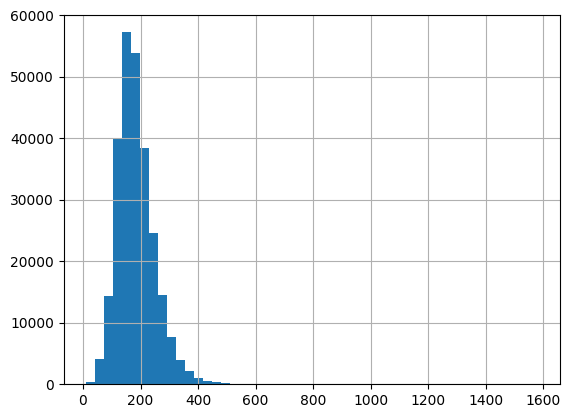

In [7]:
pd.Series(seq_len).hist(bins = 50)

In [8]:
len(set(dataset['train']['topic']))

23

In [10]:
df_pandas = dataset['train'].to_pandas()

In [11]:
df_pandas.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df_pandas.drop(columns=['id'], inplace=True)

In [13]:
df_pandas['topic'].value_counts()

topic
Россия               43492
Мир                  41915
Бывший СССР          23262
Спорт                21397
Экономика            21392
Культура             19408
Наука и техника      18764
Интернет и СМИ       17378
Из жизни             12222
Силовые структуры    11223
Дом                   9318
Ценности              7581
Бизнес                7375
Путешествия           6370
69-я параллель        1268
Крым                   666
Культпросвет           340
Легпром                114
Библиотека              65
Оружие                   3
ЧМ-2014                  2
Сочи                     1
МедНовости               1
Name: count, dtype: int64

In [14]:
new_df = df_pandas.groupby('topic').filter(lambda g: len(g) > 6000)

In [15]:
new_df['topic'].value_counts()

topic
Россия               43492
Мир                  41915
Бывший СССР          23262
Спорт                21397
Экономика            21392
Культура             19408
Наука и техника      18764
Интернет и СМИ       17378
Из жизни             12222
Силовые структуры    11223
Дом                   9318
Ценности              7581
Бизнес                7375
Путешествия           6370
Name: count, dtype: int64

In [16]:
len(new_df['topic'].value_counts())

14

In [17]:
df_pandas = new_df

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(df_pandas['topic'])

array([ 6,  6,  6, ...,  5, 11,  1])

In [19]:
df_pandas['topic'] = le.fit_transform(df_pandas['topic'])

In [20]:
df_pandas.head()

,text,topic
0,"В ЮАР произошел пожар, в результате которого п...",6
1,Давка в крупнейшем городе Кот-д'Ивуара Абиджан...,6
2,Политические партии и общественные организации...,6
3,Премьер-министр Грузии Бидзина Иванишвили в но...,1
4,"Полиция отпустила всех участников акции ""Страт...",9


In [21]:
min(le.fit_transform(df_pandas['topic']))

0

In [22]:
np.unique(df_pandas['topic'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [23]:
x = df_pandas['text']

In [24]:
y = df_pandas['topic']

In [25]:
# from sklearn.cross_validation import train_test_split

In [26]:
from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

In [28]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-sentence', num_labels=14).to("cuda")
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [29]:
tokens_train = tokenizer.batch_encode_plus(
    x_train.values,
    max_length = 400,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    x_val.values,
    max_length = 400,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    x_test.values,
    max_length = 400,
    padding = 'max_length',
    truncation = True
)

# train_seq = torch.tensor(tokens_train['input_ids'])
# train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values)

# val_seq = torch.tensor(tokens_val['input_ids'])
# val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.values)

# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values)
batch_size = 8


# train_data = TensorDataset(train_seq, train_mask, train_y)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# val_data =  TensorDataset(val_seq, val_mask, val_y)
# val_sampler = SequentialSampler(val_data)
# val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

# test_data =  TensorDataset(test_seq, test_mask, test_y)

In [30]:
from transformers import TrainingArguments, Trainer

2024-05-27 02:56:35.938807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 02:56:35.938907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 02:56:36.069593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [31]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Data(tokens_train, train_y)
val_dataset = Data(tokens_val, val_y)
test_dataset = Data(tokens_test, test_y)

In [48]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [36]:
from sklearn.metrics import f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='micro')
    return {'F1': f1}

In [50]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics = compute_metrics)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [51]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.502600,0.417755,0.867181
2,0.324600,0.427555,0.889027
3,0.224300,0.505036,0.892251


TrainOutput(global_step=54831, training_loss=0.350510243264531, metrics={'train_runtime': 22740.2717, 'train_samples_per_second': 19.289, 'train_steps_per_second': 2.411, 'total_flos': 9.01743788538288e+16, 'train_loss': 0.350510243264531, 'epoch': 3.0})

In [ ]:
model_path = "news"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [32]:
def get_prediction():
    test_pred = trainer.predict(test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
# pred = get_prediction()

In [53]:
f1_score(test_y, pred, average='micro')

0.8661623898889315

In [54]:
model.save_pretrained("./mymodel")

In [37]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-sentence', num_labels=14).to("cuda")
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 5, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 2e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [39]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics = compute_metrics)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [40]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,0.515000,0.397939,0.872686
2,0.335700,0.466610,0.886538
3,0.214300,0.638637,0.885867
4,0.110900,0.791799,0.887846
5,0.050800,0.867591,0.887048


TrainOutput(global_step=91385, training_loss=0.2453291177788768, metrics={'train_runtime': 37707.2788, 'train_samples_per_second': 19.388, 'train_steps_per_second': 2.424, 'total_flos': 1.50290631423048e+17, 'train_loss': 0.2453291177788768, 'epoch': 5.0})

In [ ]:
model_path = "news2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('news2/tokenizer_config.json',
 'news2/special_tokens_map.json',
 'news2/vocab.txt',
 'news2/added_tokens.json')

In [ ]:
pred = get_prediction()

In [ ]:
f1_score(test_y, pred, average='micro')

0.87171581769437

In [ ]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68      1475
           1       0.92      0.93      0.93      4652
           2       0.90      0.83      0.86      1864
           3       0.80      0.78      0.79      2444
           4       0.80      0.84      0.82      3476
           5       0.87      0.95      0.91      3882
           6       0.93      0.89      0.91      8383
           7       0.94      0.90      0.92      3753
           8       0.81      0.84      0.82      1274
           9       0.89      0.80      0.84      8699
          10       0.72      0.86      0.79      2245
          11       0.96      0.98      0.97      4279
          12       0.95      0.92      0.93      1516
          13       0.82      0.85      0.83      4278

    accuracy                           0.87     52220
   macro avg       0.85      0.87      0.86     52220
weighted avg       0.88      0.87      0.87     52220

